# Visualize simulated data

In order to start making interpretations we will generate two visualizations of our data

1. We will verify that the simulated dataset is a good representation of our original input dataset by visually comparing the structures in the two datasets projected onto UMAP space.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import ast
import pandas as pd
import numpy as np
import random
from plotnine import (ggplot, 
                      geom_point,
                      labs,
                      aes, 
                      facet_wrap, 
                      scale_colour_manual,
                      guides, 
                      guide_legend, 
                      theme_bw, 
                      theme,  
                      element_text,
                      element_rect,
                      element_line,
                      element_blank,
                      ggsave)

from sklearn.decomposition import PCA
from keras.models import load_model
import umap

import warnings
warnings.filterwarnings(action='ignore')

from numpy.random import seed
randomState = 123
seed(randomState)

/home/alexandra/anaconda3/envs/batch_effects/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# User parameters
dataset_name = "Pseudomonas_analysis"
analysis_name = 'analysis_0'
NN_architecture = 'NN_2500_30'

In [3]:
# Load data
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../"))    # base dir on repo
local_dir = "/home/alexandra/Documents"                          # base dir on local machine for data storage

NN_dir = base_dir + "/" + dataset_name + "/models/" + NN_architecture
latent_dim = NN_architecture.split('_')[-1]

normalized_data_file = os.path.join(
    base_dir,
    dataset_name,
    "data",
    "input",
    "train_set_normalized.pcl")

model_encoder_file = os.path.join( ## Make more explicit name here
    NN_dir,
    "tybalt_2layer_{}latent_encoder_model.h5".format(latent_dim))

weights_encoder_file = os.path.join(
    NN_dir,
    "tybalt_2layer_{}latent_encoder_weights.h5".format(latent_dim))

model_decoder_file = os.path.join(
    NN_dir,
    "tybalt_2layer_{}latent_decoder_model.h5".format(latent_dim))

weights_decoder_file = os.path.join(
    NN_dir,
    "tybalt_2layer_{}latent_decoder_weights.h5".format(latent_dim))

simulated_data_file = os.path.join(
    local_dir,
    "Data",
    "Batch_effects",
    "simulated",
    analysis_name,
    "simulated_data.txt.xz")

In [4]:
NN_dir

'/home/alexandra/Documents/Repos/Batch_effects_simulation/Pseudomonas_analysis/models/NN_2500_30'

In [5]:
# Output files
umap_overlay_file = os.path.join(
    base_dir,
    "results",
    "Pa_umap_overlay.png")

In [6]:
# Load saved models
loaded_model = load_model(model_encoder_file)
loaded_decode_model = load_model(model_decoder_file)

loaded_model.load_weights(weights_encoder_file)
loaded_decode_model.load_weights(weights_decoder_file)

In [7]:
# Read data
normalized_data = pd.read_table(
    normalized_data_file,
    header=0,
    sep='\t',
    index_col=0).T

simulated_data = pd.read_table(
    simulated_data_file,
    header=0,
    sep='\t',
    index_col=0)

print(normalized_data.shape)
print(simulated_data.shape)

(950, 5549)
(6000, 5549)


In [8]:
normalized_data.head(10)

Gene_symbol,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
05_PA14000-4-2_5-10-07_S2.CEL,0.853357,0.725280,0.640617,0.811465,0.694460,0.533958,0.158865,0.889579,0.884945,0.176558,...,0.466871,0.702785,0.790965,0.893249,0.789939,0.164157,0.970470,0.887472,0.900484,0.880012
54375-4-05.CEL,0.778790,0.767873,0.614859,0.907865,0.398800,0.460849,0.113876,0.761351,0.801740,0.222709,...,0.352020,0.694387,0.733186,0.639074,0.681204,0.110301,0.619554,0.747656,0.749893,0.805374
AKGlu_plus_nt_7-8-09_s1.CEL,0.789155,0.729508,0.725913,0.718989,0.530160,0.466327,0.079507,0.731643,0.827707,0.241847,...,0.392405,0.700352,0.773422,0.791118,0.931585,0.172570,0.797148,0.753785,0.856253,0.811099
anaerobic_NO3_1.CEL,0.716320,0.585079,0.390211,0.193248,0.279456,0.301781,0.513547,0.342051,0.415668,0.125914,...,0.398308,0.419574,0.593955,0.527203,0.706524,0.205510,0.504767,0.105662,0.363409,0.544780
anaerobic_NO3_2.CEL,0.658015,0.592172,0.410331,0.245504,0.312028,0.305852,0.513499,0.336723,0.334226,0.162965,...,0.407801,0.478697,0.571460,0.473054,0.669643,0.155548,0.562927,0.049738,0.388931,0.548814
control1aerobic_Pae_G1a.CEL,0.365512,0.572967,0.417762,0.663096,0.424846,0.606590,0.378900,0.224257,0.161582,0.074461,...,0.491161,0.565151,0.595824,0.382989,0.352268,0.250905,0.362161,0.487777,0.729434,0.483384
control1_anaerobic_Pae_G1a.CEL,0.689254,0.723461,0.510094,0.801569,0.619374,0.937262,0.138600,0.298615,0.306533,0.032482,...,0.754845,0.711126,0.589279,0.542699,0.591066,0.421389,0.392671,0.686055,0.911163,0.585208
control2aerobic_Pae_G1a.CEL,0.353000,0.580626,0.302544,0.639624,0.281793,0.687343,0.462645,0.000000,0.107961,0.093163,...,0.466139,0.545104,0.487957,0.330583,0.419139,0.328478,0.298493,0.254059,0.588305,0.406311
control2_anaerobic_Pae_G1a.CEL,0.674305,0.680740,0.515478,0.747121,0.656701,0.910654,0.149744,0.262492,0.263528,0.019910,...,0.775338,0.653142,0.642205,0.550935,0.565532,0.458622,0.426767,0.701314,0.886074,0.556363
control3aerobic_Pae_G1a.CEL,0.399186,0.653977,0.328755,0.692895,0.482482,0.618446,0.308135,0.191401,0.201170,0.020375,...,0.560889,0.654797,0.493961,0.454766,0.464733,0.456465,0.348577,0.503229,0.718768,0.474649


In [9]:
simulated_data.head(10)

,0,1,2,3,4,5,6,7,8,9,...,5539,5540,5541,5542,5543,5544,5545,5546,5547,5548
0,0.690,0.643,0.455,0.651,0.375,0.414,0.354,0.567,0.447,0.165,...,0.376,0.600,0.563,0.640,0.662,0.325,0.577,0.567,0.708,0.615
1,0.691,0.655,0.527,0.681,0.372,0.443,0.374,0.533,0.503,0.166,...,0.291,0.591,0.610,0.585,0.597,0.163,0.460,0.532,0.710,0.699
2,0.826,0.695,0.510,0.643,0.611,0.518,0.344,0.631,0.663,0.200,...,0.589,0.582,0.596,0.672,0.753,0.161,0.522,0.511,0.748,0.728
3,0.601,0.565,0.417,0.595,0.383,0.440,0.387,0.466,0.402,0.224,...,0.346,0.548,0.471,0.460,0.565,0.256,0.510,0.348,0.579,0.583
4,0.622,0.616,0.473,0.600,0.402,0.481,0.364,0.445,0.448,0.216,...,0.451,0.532,0.589,0.547,0.578,0.234,0.425,0.502,0.705,0.717
5,0.736,0.733,0.546,0.633,0.461,0.437,0.325,0.573,0.682,0.203,...,0.414,0.576,0.693,0.643,0.747,0.215,0.510,0.639,0.775,0.746
6,0.643,0.648,0.450,0.552,0.408,0.422,0.372,0.552,0.531,0.185,...,0.393,0.504,0.558,0.506,0.600,0.214,0.478,0.443,0.641,0.686
7,0.517,0.568,0.364,0.484,0.346,0.441,0.442,0.475,0.372,0.156,...,0.368,0.488,0.461,0.446,0.480,0.364,0.478,0.388,0.528,0.492
8,0.747,0.746,0.622,0.749,0.456,0.500,0.261,0.626,0.641,0.206,...,0.421,0.636,0.681,0.676,0.637,0.241,0.595,0.664,0.725,0.708
9,0.581,0.586,0.419,0.593,0.368,0.406,0.403,0.446,0.450,0.213,...,0.420,0.535,0.509,0.492,0.525,0.258,0.409,0.430,0.594,0.573


In [10]:
# Get and save model
model = umap.UMAP(random_state=randomState).fit(normalized_data)

input_data_UMAPencoded = model.transform(normalized_data)
input_data_UMAPencoded_df = pd.DataFrame(data=input_data_UMAPencoded,
                                         index=normalized_data.index,
                                         columns=['1','2'])


In [11]:
# UMAP embedding of simulated data
simulated_data_UMAPencoded = model.transform(simulated_data)
simulated_data_UMAPencoded_df = pd.DataFrame(data=simulated_data_UMAPencoded,
                                         index=simulated_data.index,
                                         columns=['1','2'])

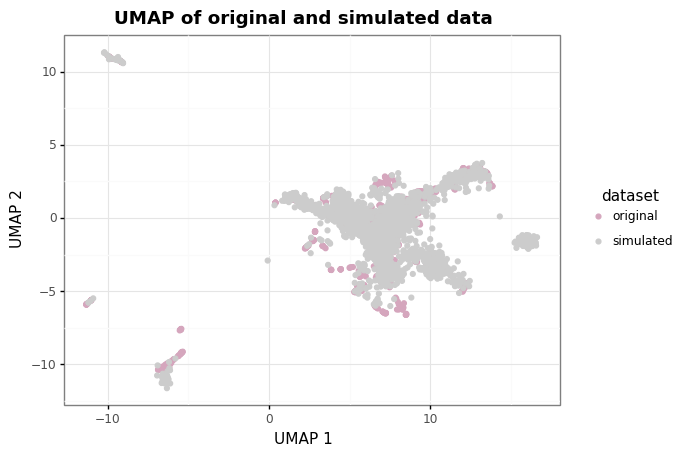

<ggplot: (8763788596330)>


In [12]:
# Overlay original input vs simulated data

# Add label for input or simulated dataset
input_data_UMAPencoded_df['dataset'] = 'original'
simulated_data_UMAPencoded_df['dataset'] = 'simulated'

# Concatenate input and simulated dataframes together
combined_data_df = pd.concat([input_data_UMAPencoded_df, simulated_data_UMAPencoded_df])

# Plot
g_input_sim = ggplot(combined_data_df, aes(x='1', y='2')) \
+ geom_point(aes(color='dataset'), alpha=0.2) \
+ labs(x = "UMAP 1", y = "UMAP 2", title = "UMAP of original and simulated data") \
+ theme_bw() \
+ theme(
    legend_title_align = "center",
    plot_background=element_rect(fill='white'),
    legend_key=element_rect(fill='white', colour='white'), 
    plot_title=element_text(weight='bold')
) \
+ guides(colour=guide_legend(override_aes={'alpha': 1})) \
+ scale_colour_manual(['#d5a6bdff', "#ccccccff"]) 

print(g_input_sim)
ggsave(plot = g_input_sim, filename = umap_overlay_file, dpi=500)